# Backtesting

## What is the "挖因子" in quantitative trading?

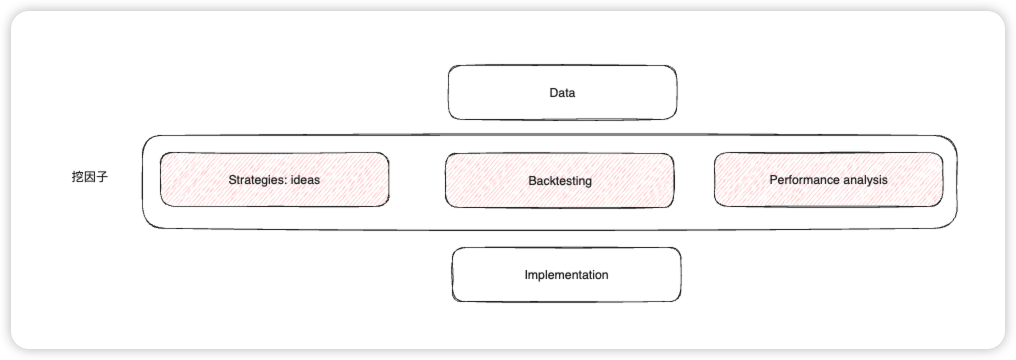

## Data

In [54]:
import ccxt
import pandas as pd
import talib

In [81]:
exchange = ccxt.okx({})
# exchange.set_sandbox_mode(True)
exchange.load_markets()
exchange.verbose = False

In [82]:
ohlcv = exchange.fetch_ohlcv('BTC/USDT', '1d')
ori_df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
ori_df['timestamp'] = pd.to_datetime(ori_df['timestamp'], unit='ms')

## Strategy idea

### EMA strategy

In [84]:
"""
fast line = EMA(9)
slow line = EMA(21)

When fast line crosses above slow line, buy
When fast line crosses below slow line, sell
"""

'\nfast line = EMA(9)\nslow line = EMA(21)\n\nWhen fast line crosses above slow line, buy\nWhen fast line crosses below slow line, sell\n'

In [85]:
ori_df['return'] = ori_df['close'].pct_change()

In [86]:
ori_df['EMA_fast'] = ori_df['close'].ewm(span=9, adjust=False).mean()
ori_df['EMA_slow'] = ori_df['close'].ewm(span=21, adjust=False).mean()

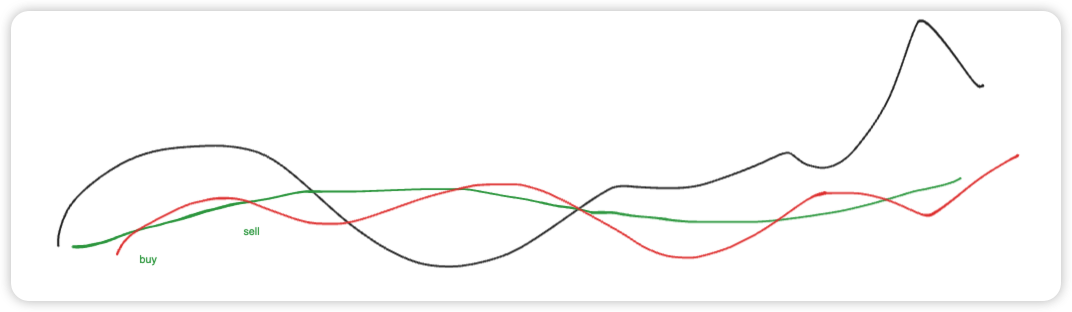

## Backtesting

### Method 1: Vetorization backtesting (long-short)


In [87]:
df = ori_df.copy()

In [88]:
df['position'] = 0  # Initialize signal column with 0
# Set signal as 1 (buy signal) when EMA_fast is greater than EMA_slow
df.loc[df['EMA_fast'] > df['EMA_slow'], 'position'] = 1
# Set signal as -1 (sell signal) when EMA_fast is less than or equal to EMA_slow
df.loc[df['EMA_fast'] < df['EMA_slow'], 'position'] = -1
df

,timestamp,open,high,low,close,volume,return,EMA_fast,EMA_slow,position
0,2024-01-28,42120.1,42838.2,41617.2,42033.2,7021.706891,NaN,42033.200000,42033.200000,0
1,2024-01-29,42036.7,43300.0,41799.5,43296.9,12314.056690,0.030064,42285.940000,42148.081818,1
2,2024-01-30,43297.0,43884.4,42690.1,42941.8,15829.493221,-0.008202,42417.112000,42220.238017,1
3,2024-01-31,42941.8,43748.8,42288.8,42576.0,14559.016811,-0.008519,42448.889600,42252.580015,1
4,2024-02-01,42576.0,43286.2,41868.2,43086.8,11603.775709,0.011997,42576.471680,42328.418195,1
...,...,...,...,...,...,...,...,...,...,...
95,2024-05-02,58341.9,59661.6,56953.1,59062.2,12543.620198,0.012348,61768.582683,63619.055980,-1
96,2024-05-03,59062.2,63349.9,58800.0,62875.9,14714.379192,0.064571,61990.046146,63551.496345,-1
97,2024-05-04,62876.0,64545.3,62548.5,63894.1,7450.483680,0.016194,62370.856917,63582.642132,-1
98,2024-05-05,63894.2,64652.4,62884.7,64017.7,6267.574366,0.001934,62700.225534,63622.192847,-1


In [ ]:
df['last_3 days return'] = df['return'].rolling(3).sum()
df['last_5 days return'] = df['return'].rolling(5).sum()
df['last_2 days EMA'] = df['close'].ewm(span=2, adjust=False).mean()



In [147]:
df.iloc[0:4]

,timestamp,open,high,low,close,volume,return,EMA_fast,EMA_slow,position,roi
0,2024-01-28,42120.1,42838.2,41617.2,42033.2,7021.706891,NaN,42033.2000,42033.200000,0,NaN
1,2024-01-29,42036.7,43300.0,41799.5,43296.9,12314.056690,0.030064,42285.9400,42148.081818,1,0.000000
2,2024-01-30,43297.0,43884.4,42690.1,42941.8,15829.493221,-0.008202,42417.1120,42220.238017,1,-0.008202
3,2024-01-31,42941.8,43748.8,42288.8,42576.0,14559.016811,-0.008519,42448.8896,42252.580015,1,-0.008519


In [89]:
df['roi'] = df['return'] * df['position'].shift()
return_df = df['roi'].fillna(0).cumsum()

<Axes: >

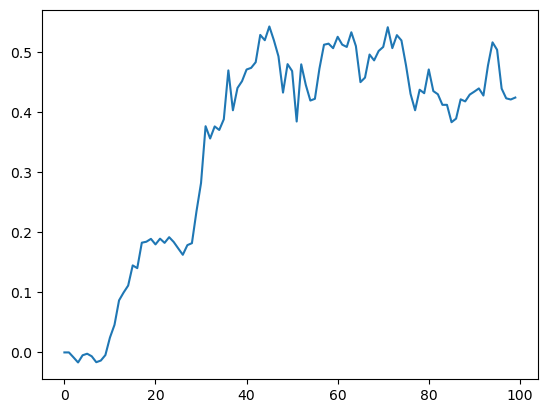

In [91]:
return_df.plot()

### Method 2: Event-driven backtesting

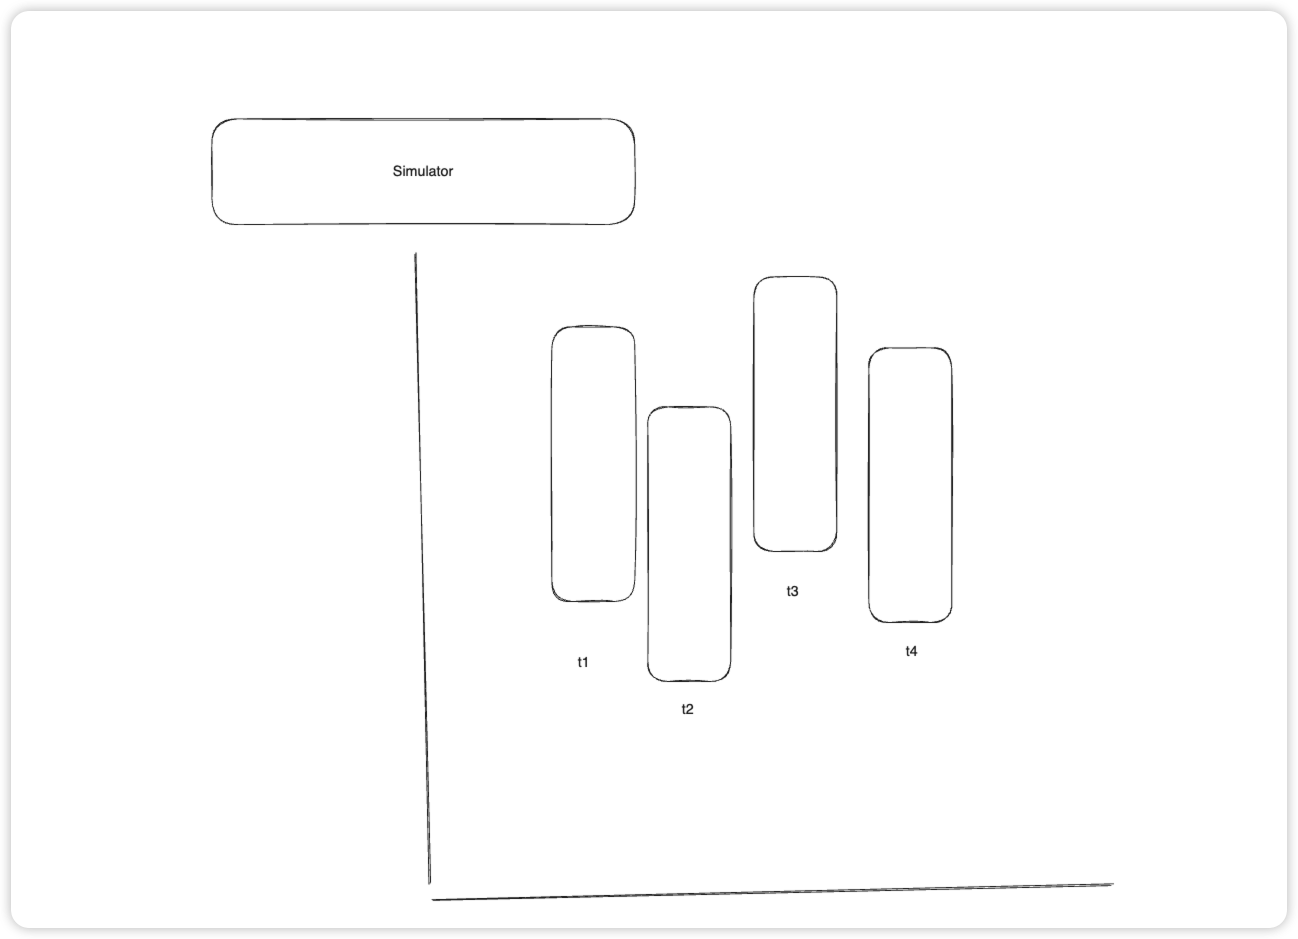

In [95]:
! pip3 install backtesting

  Using cached Backtesting-0.3.3-py3-none-any.whl


In [97]:
from backtesting import Strategy
from backtesting.lib import crossover

In [108]:
def EMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).ewm(span=n, min_periods=n).mean()

In [150]:
from backtesting import Strategy
from backtesting.lib import crossover


class EMAStrategy(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 2
    n2 = 9
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
    
    def next(self):
            
        if crossover(self.ema1, self.ema2):
            self.position.close()
            self.buy()

        elif crossover(self.ema1, self.ema2):
            self.position.close()
            self.sell()

In [130]:
data = ori_df.copy().set_index('timestamp')

In [131]:
data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

In [151]:
from backtesting import Backtest

bt = Backtest(data, EMAStrategy, cash=10000000, commission=.002)
stats = bt.run()
stats

Start                     2024-01-28 00:00:00
End                       2024-05-06 00:00:00
Duration                     99 days 00:00:00
Exposure Time [%]                        90.0
Equity Final [$]                14670751.7116
Equity Peak [$]                 16882267.3612
Return [%]                          46.707517
Buy & Hold Return [%]               51.812615
Return (Ann.) [%]                  305.089643
Volatility (Ann.) [%]              262.129483
Sharpe Ratio                         1.163889
Sortino Ratio                        8.272708
Calmar Ratio                        14.791947
Max. Drawdown [%]                  -20.625388
Avg. Drawdown [%]                   -4.392789
Max. Drawdown Duration       54 days 00:00:00
Avg. Drawdown Duration       10 days 00:00:00
# Trades                                    6
Win Rate [%]                             50.0
Best Trade [%]                       30.07781
Worst Trade [%]                     -5.934117
Avg. Trade [%]                    

In [152]:
bt.plot()

Row(id='4984', ...)

|                               | Evendriven backtesting                                                   | Vectorization                                        |
| ----------------------------- | ------------------------------------------------------------ | ---------------------------------------------------- |
| Speed                         | slow                                                      | fast                    |
| Parallelism,  multiple stocks | Built-in and optimized                                       | Depending on the pandas                              |
| Learning Curve                | High                                                         | Low                                                  |
| Suitable                      | Can handle complex scenarios, including non-vectorizable operation or dynamic decision-making at each step. | Suitable for vectorizable operations                 |
| Implementation Efficiency     | Slower                                                       | Quick                                                |
| Realism                       | more realism                                                 | sacrifice some realism                               |
| Coding lines                  | 162 lines                                                    | 28 lines                                             |
| Readable                      | Higher (Needs to learn it firstly)                           | Lower (different people have different coding style) |
| Extendable or maintainable    | Better(it is module-based)                                   | Lower(needs to run again and again)                  |
|                               |                                                              |                                                      |


## Portfolio analysis `quantstats`

In [153]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('META')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
stock.sharpe()

[*********************100%%**********************]  1 of 1 completed


0.7143288921799867